In [ ]:
"""
"Створення моделі машинного навчання для прогнозування ціни на житло (квартира, таунхаус, будинок) в місті Рівне"

Джерела:

realtor.ua
https://rieltor.ua/rovno/flats-sale/?sort=-byprice#9.05/50.7127/26.6092
dom.ria.com
https://dom.ria.com/uk/realty-prodaja-kvartira-rovno-tsentr-mira-prospekt-26769486.html
forbes.ua
https://forbes.ua/money/budivnitstva-ne-zapuskayutsya-popitu-nemae-ale-tsini-ne-padayut-doslidzhennya-rinku-nerukhomosti-pid-chas-viyni-vid-ernst-amp-young-13032023-12337
M2Bomber
https://ua.m2bomber.com/stat/448930/view/rivne?type=flat-sell

Примітки:

Вартість в доларах із-за нестабільності курса валют

Висновок:

Під час воєнних дій на території України спостерігалося істотне зниження обсягів будівництва житлових та 
комерційних споруд. Втім, місто Рівне виявилося винятком із загальної тенденції. У цьому регіоні 
зареєстровано зростання вартості нерухомості та кількості пропозицій на ринку. Проте, попри збільшення 
пропозиції, попит залишається в стагнації (стабільним), що може бути обумовлено значною кількістю переселенців
та громадян які використовують державну програму єОселя, а також громадян які мають фінансові можливості 
для здійснення інвестицій у нерухомість (Люди зі сходу та центру частіше купують нерухомість в даному місті).

Спрогнозувати ціни на нерухомість більш точно можливо тільки за стабілізацією економічної ситуації в країні, та 
збором додаткових даних...

"Будівництво скоротилоcя майже всюди, попит обвалився, але ціни не падають". 
Дослідження ринку нерухомості під час війни від Ernst & Young. 

"""

In [1]:
import pandas as pd
import numpy as np
import os
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from xgboost import XGBRegressor
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy import stats

In [2]:
# завантаження файлу щоб код працював на інших платформах і незалежно від шляхів до файлів.
data = "data2.xlsx"
file_path = os.path.join(os.getcwd(), data)

if os.path.exists(file_path):
    df = pd.read_excel(file_path)
else:
    print(f"Файл {data} не знайдений.")

# Тепер мій датасет зберігається в об'єкті DataFrame з Pandas (df)


In [3]:
# Виведення перших 5 рядків датасету
print(df.head())

      Район Тип житла  Загальна площа (м²)  Кількість кімнат  \
0  12-школа   Будинок                   59                 3   
1  12-школа   Будинок                   90                 2   
2  12-школа  Таунхауз                  151                 3   
3  12-школа   Будинок                  240                 4   
4  12-школа   Будинок                   90                 2   

   1 новий / 2 вторични й ринок  к-сть поверхів будинку  Вартість  \
0                             2                       1     96996   
1                             2                       1    135000   
2                             2                       2    250056   
3                             2                       2    340080   
4                             2                       1    135000   

   Своя Парковка (1-є 0-не має)  Земельний участок (соток)  \
0                             1                          4   
1                             1                          6   
2             

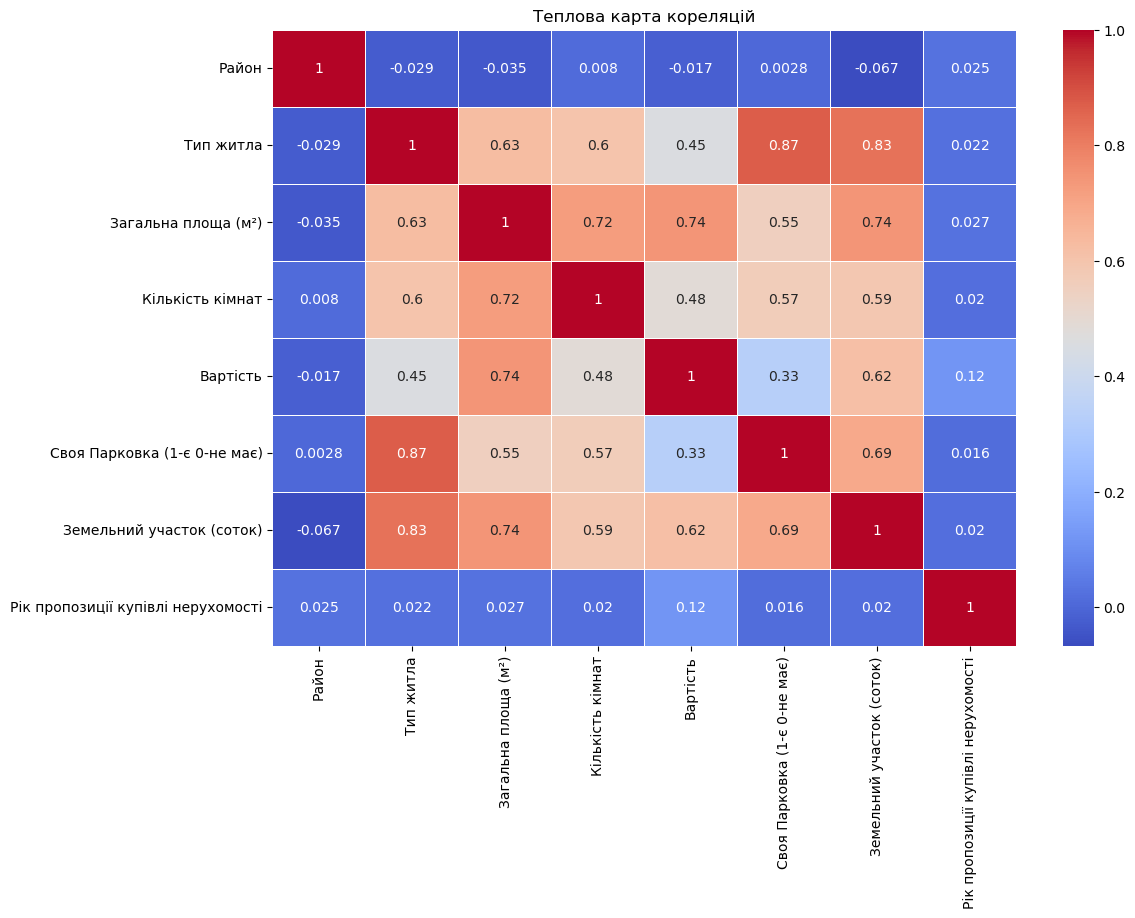

In [58]:
# приховати попередження
warnings.filterwarnings("ignore")

# візуалізація залежностей між даними датасету
"""
Позитивна кореляція (значення більше 0) вказує що, якщо одна змінна зростає, інша також зростає.
Негативна кореляція (значення менше 0) означає, що, якщо одна змінна зростає, інша зменшується. Тобто обидві змінні рухаються в протилежних напрямках.
Відсутність кореляції (значення близьке до 0) означає, що між змінними немає сильного статистичного зв'язку.
"""

correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Теплова карта кореляцій')
plt.show()

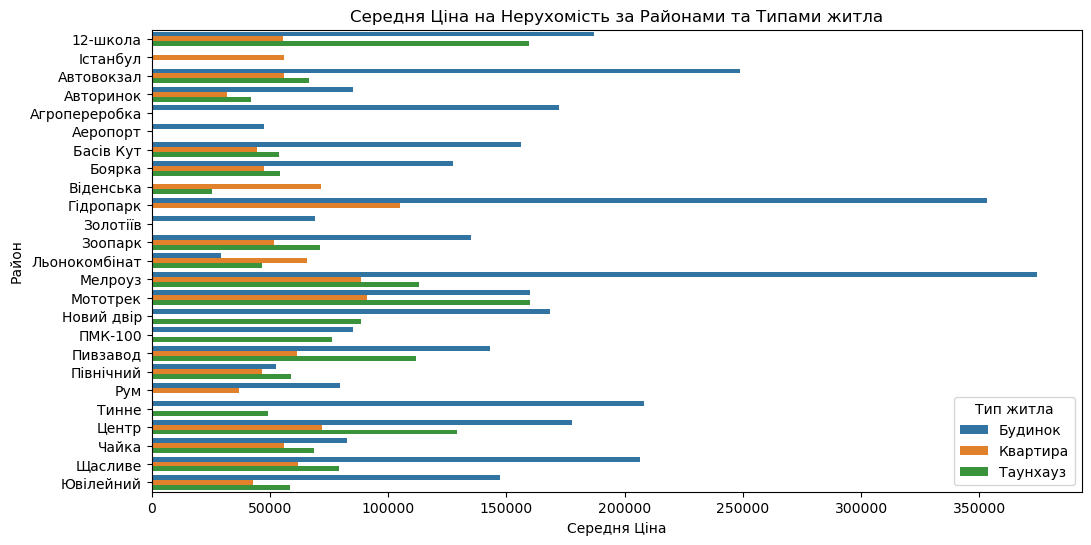

In [5]:
# Групування даних за районом та типом житла та обчислення середньої ціни
grouped_data = df.groupby(['Район', 'Тип житла'])['Вартість'].mean().reset_index()

# Створення графіка "bar plot" з розділенням за типом житла
plt.figure(figsize=(12, 6))
sns.barplot(x='Вартість', y='Район', hue='Тип житла', data=grouped_data, orient='h')
plt.xlabel('Середня Ціна')
plt.ylabel('Район')
plt.title('Середня Ціна на Нерухомість за Районами та Типами житла')
plt.show()


In [6]:
# Групування даних за роками і обчислення середнього значення цін
average_prices_by_year = df.groupby(['Рік пропозиції купівлі нерухомості'])['Вартість'].mean().reset_index()

# Додавання стовпця для відсотку зміни
average_prices_by_year['Відсоток зміни'] = average_prices_by_year['Вартість'].pct_change() * 100

# Вивід результату
print(average_prices_by_year)

   Рік пропозиції купівлі нерухомості      Вартість  Відсоток зміни
0                                2020  66860.872624             NaN
1                                2021  77502.884007       15.916650
2                                2022  89911.518900       16.010546
3                                2023  90434.551020        0.581719


In [7]:
# забираю стовпчики які мають менше залежностей з вартістю нерухомості за даними теплової карти кореляціїб але залишаємо рік

columns_to_drop = ['к-сть поверхів будинку', '1 новий / 2 вторични й ринок']
df = df.drop(columns=columns_to_drop, axis=1)

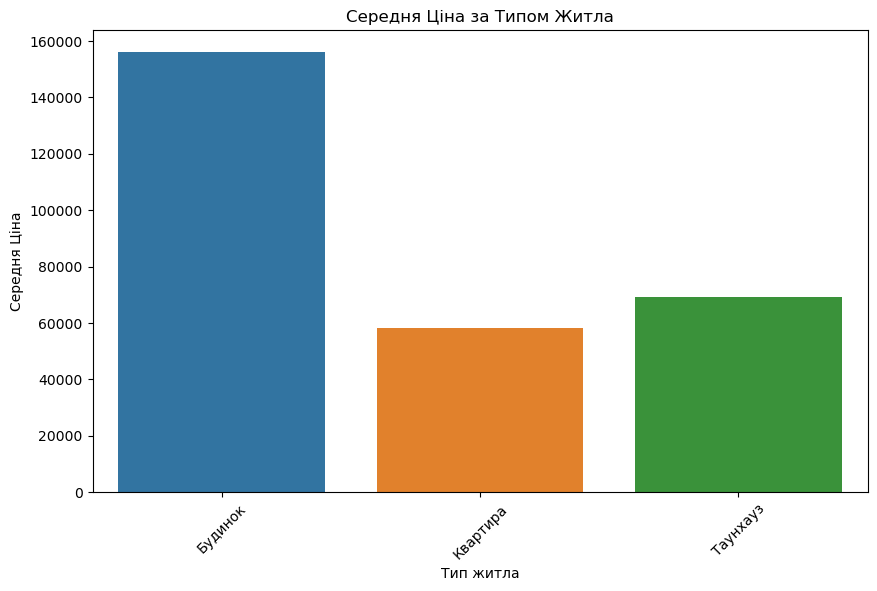

In [8]:
# Групування даних за типом житла і обчислення середньої ціни
grouped_data = df.groupby('Тип житла')['Вартість'].mean().reset_index()

# Створення графіка "bar plot"
plt.figure(figsize=(10, 6))
sns.barplot(x='Тип житла', y='Вартість', data=grouped_data)
plt.xlabel('Тип житла')
plt.ylabel('Середня Ціна')
plt.title('Середня Ціна за Типом Житла')
plt.xticks(rotation=45)  
# Обертання підписів по вісі X для кращої читабельності
plt.show()


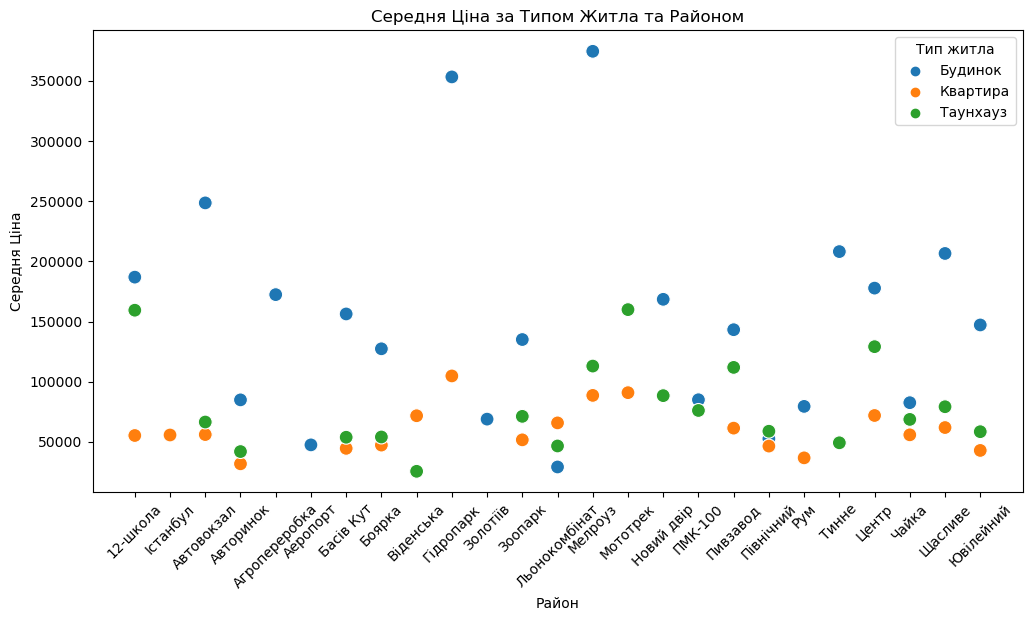

In [9]:
# Групування даних за районом і типом житла і обчислення середньої ціни
grouped_data = df.groupby(['Район', 'Тип житла'])['Вартість'].mean().reset_index()

# Створення графіка
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Район', y='Вартість', hue='Тип житла', data=grouped_data, s=100)
plt.xlabel('Район')
plt.ylabel('Середня Ціна')
plt.title('Середня Ціна за Типом Житла та Районом')
plt.xticks(rotation=45)  # Обертання підписів по вісі X для кращої читабельності
plt.legend(title='Тип житла')
plt.show()

Індекси викидів:
(array([   3,    6,   30,   33,  111,  139,  164,  276,  277,  297,  298,
        536,  539,  542,  545,  588,  622,  655,  872,  873,  881,  882,
        889,  898,  946,  972, 1353, 1432, 1490, 1712, 1713, 1774, 1778,
       1838, 1892, 1933, 1987, 1988, 1989, 2075, 2084, 2085, 2086, 2170,
       2177, 2178, 2262, 2269, 2270]),)


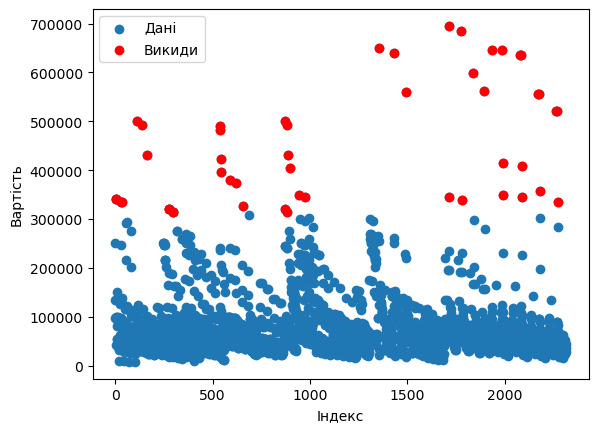

In [10]:
# шукаємо викиди в даних вартості
column_name = 'Вартість'

# рівень для Z-оцінки (в документації всі ставлять 3)
threshold = 3

z_scores = stats.zscore(df[column_name])

# індекси викидів
outliers_indices = np.where(np.abs(z_scores) > threshold)

# вивожу індекси викидів
print("Індекси викидів:")
print(outliers_indices)

# графік
plt.scatter(df.index, df[column_name], label='Дані')
plt.scatter(outliers_indices, df.loc[outliers_indices][column_name], color='red', label='Викиди')
plt.xlabel('Індекс')
plt.ylabel(column_name)
plt.legend()
plt.show()

In [11]:
# Видаляємо рядки з викидами із DataFrame
df_cleaned = df.drop(outliers_indices[0])

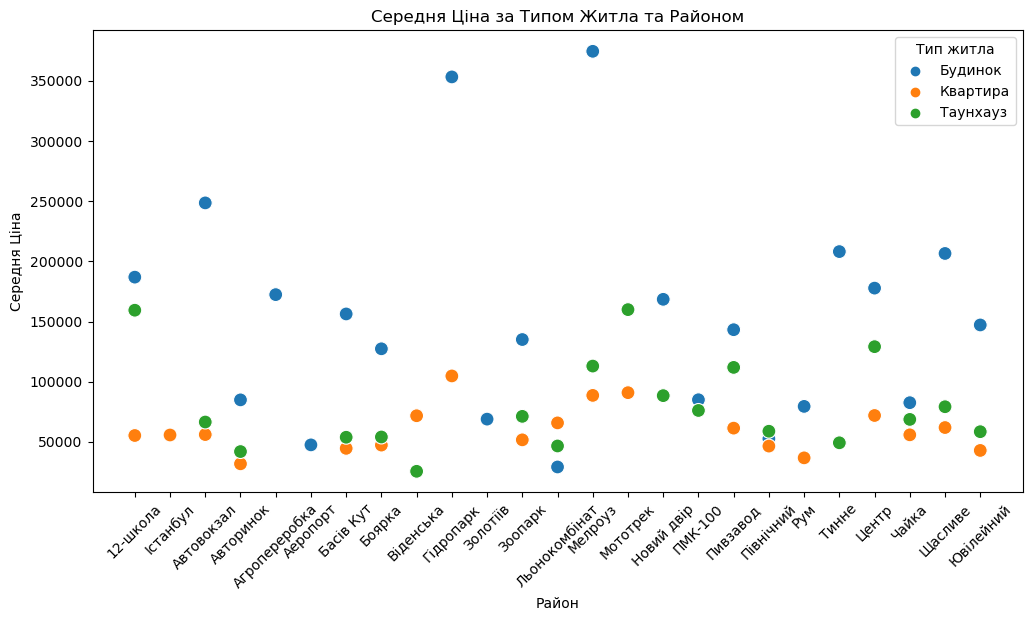

In [12]:
# Групування даних за районом і типом житла і обчислення середньої ціни
grouped_data = df.groupby(['Район', 'Тип житла'])['Вартість'].mean().reset_index()

# Створення графіка
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Район', y='Вартість', hue='Тип житла', data=grouped_data, s=100)
plt.xlabel('Район')
plt.ylabel('Середня Ціна')
plt.title('Середня Ціна за Типом Житла та Районом')
plt.xticks(rotation=45)  # Обертання підписів по вісі X для кращої читабельності
plt.legend(title='Тип житла')
plt.show()

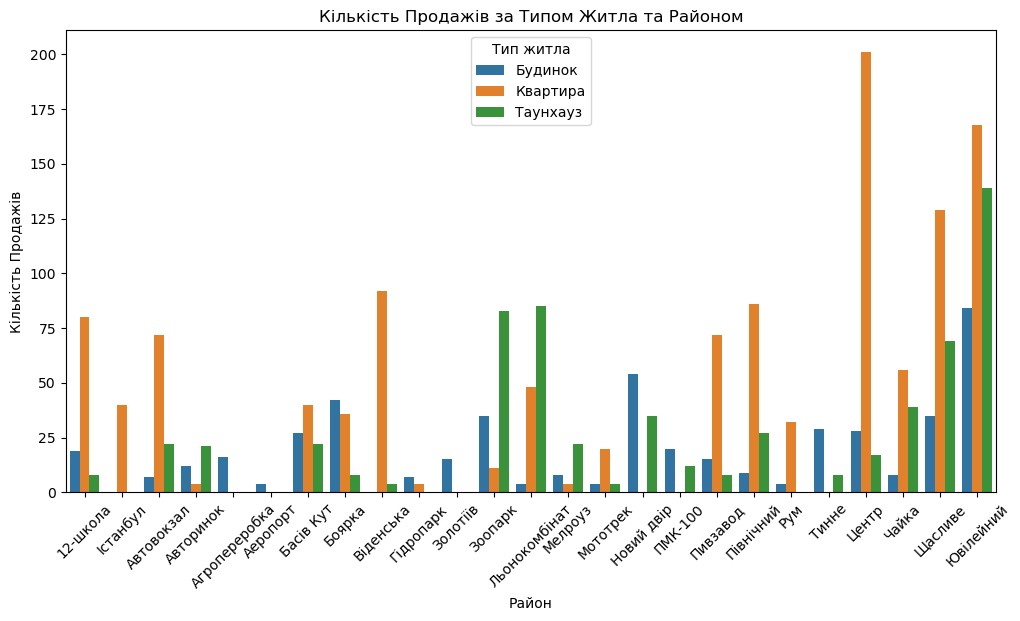

In [13]:
# Групування даних за районом і типом житла і підрахунок кількості виставлених на продажу об'єктів
count_data = df.groupby(['Район', 'Тип житла'])['Вартість'].count().reset_index()

# Створення графіка "bar plot"
plt.figure(figsize=(12, 6))
sns.barplot(x='Район', y='Вартість', hue='Тип житла', data=count_data)
plt.xlabel('Район')
plt.ylabel('Кількість Продажів')
plt.title('Кількість Продажів за Типом Житла та Районом')
plt.xticks(rotation=45)  # Обертання підписів по вісі X для кращої читабельності
plt.legend(title='Тип житла')
plt.show()


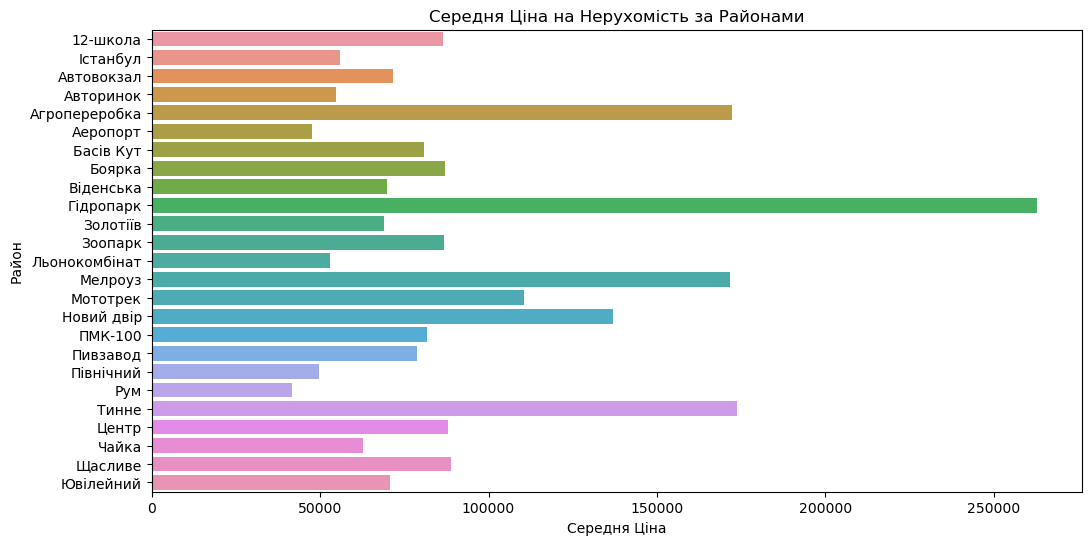

In [14]:
# Групування даних за районом і обчислення середньої ціни
grouped_data = df.groupby('Район')['Вартість'].mean().reset_index()

# Створення графіка "bar plot"
plt.figure(figsize=(12, 6))
sns.barplot(x='Вартість', y='Район', data=grouped_data, orient='h')
plt.xlabel('Середня Ціна')
plt.ylabel('Район')
plt.title('Середня Ціна на Нерухомість за Районами')
plt.show()


In [15]:
# Переводимо категоріальні ознаки стовпчика "Район" та "тип житла" в числовий формат. 
# ВА першій версії ми використовуєвали One-Hot Encoding тепер ми поставимо свої значення

# Замінюю категоріальні значення типу житла на числові
df['Тип житла'] = df['Тип житла'].replace({'Квартира': 1, 'Таунхауз': 2, 'Будинок': 3})

# замінюю значеня в стовпці 'Район' на числові
df['Район'] = df['Район'].replace({
    '12-школа': 1,
    'Автовокзал': 2,
    'Авторинок': 3,
    'Агропереробка': 4,
    'Аеропорт': 5,
    'Басів Кут': 6,
    'Боярка': 7,
    'Віденська': 8,
    'Гідропарк': 9,
    'Золотіїв': 10,
    'Зоопарк': 11,
    'Істанбул': 12,
    'Льонокомбінат': 13,
    'Мелроуз': 14,
    'Мототрек': 15,
    'Новий двір': 16,
    'Пивзавод': 17,
    'Північний': 18,
    'ПМК-100': 19,
    'Рум': 20,
    'Тинне': 21,
    'Центр': 22,
    'Чайка': 23,
    'Щасливе': 24,
    'Ювілейний': 25
})
# оновлений датасет
df.head()

,Район,Тип житла,Загальна площа (м²),Кількість кімнат,Вартість,Своя Парковка (1-є 0-не має),Земельний участок (соток),Рік пропозиції купівлі нерухомості
0,1,3,59,3,96996,1,4,2023
1,1,3,90,2,135000,1,6,2023
2,1,2,151,3,250056,1,4,2023
3,1,3,240,4,340080,1,7,2023
4,1,3,90,2,135000,1,6,2023


In [16]:
# тепер пробуємо створити та навчати модель машиного навчання

# Розділення даних на ознаки (X) і цільову змінну (y)
X = df.drop('Вартість', axis=1)  # Вилучення цільової змінної
y = df['Вартість']

# Розділення даних на навчальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Пробуємо створити модель лінійної регресії
model = LinearRegression()

# Тренування моделі на навчальних даних
model.fit(X_train, y_train)

# Оцінка точності моделі на тестових даних
accuracy = model.score(X_test, y_test)
print(f'Accuracy (R-squared) of Linear Regression: {accuracy}')

y_pred_linear = model.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
print(f'Mean Squared Error (MSE) of Linear Regression: {mse_linear}')


Accuracy (R-squared) of Linear Regression: 0.6158874339820114
Mean Squared Error (MSE) of Linear Regression: 2469314687.923206


In [18]:
# Пробуємо використовувати ансамблі, створимо модель випадкового лісу
rf_model = RandomForestRegressor(n_estimators=100, random_state=0)

# Тренування моделі на навчальних даних
rf_model.fit(X_train, y_train)

# Оцінка точності моделі на тестових даних
rf_accuracy = rf_model.score(X_test, y_test)
print(f'Accuracy (R-squared) of Random Forest: {rf_accuracy}')

y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Mean Squared Error (MSE) of Random Forest: {mse_rf}')

Accuracy (R-squared) of Random Forest: 0.9765918016470654
Mean Squared Error (MSE) of Random Forest: 150482470.82865372


In [19]:
# Пропуємо нові дані з навченою моделю під назвою rf_model

new_data = pd.DataFrame({
    'Район': [10],  # Код району (ваші дані)
    'Тип житла': [2],  # Тип житла (ваші дані)
    'Загальна площа (м²)': [230],  # Загальна площа (ваші дані)
    'Кількість кімнат': [2],  # Кількість кімнат (ваші дані)
    'Своя Парковка (1-є 0-не має)': [1],  # Ось тут додана кома
    'Земельний участок (соток)': [4],  # Кількість соток землі (ваші дані)
    'Рік пропозиції купівлі нерухомості': [2024],  # Рік цифрою (ваші дані)
})

# Прогнозуйте вартість за допомогою навченої моделі
predicted_price = rf_model.predict(new_data)

# Виводьте прогноз вартості
print("Прогноз вартості:", predicted_price)


Прогноз вартості: [234135.47]


In [20]:
# Тепер пробуємо градієнтний бустинг:

gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=0)

# Тренування моделі на навчальних даних
gb_model.fit(X_train, y_train)

# Оцінка точності моделі на тестових даних
gb_accuracy = gb_model.score(X_test, y_test)
print(f'Accuracy (R-squared) of Gradient Boosting: {gb_accuracy}')

y_pred_gb = gb_model.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
print(f'Mean Squared Error (MSE) of Gradient Boosting: {mse_gb}')

Accuracy (R-squared) of Gradient Boosting: 0.9152389668259396
Mean Squared Error (MSE) of Gradient Boosting: 544896685.7555281


In [29]:
# створюємо та навчаємо модель нейроної мережі 

# Розділення даних на ознаки (X) і цільову змінну (y)
X = df.drop('Вартість', axis=1)  # Вилучення цільової змінної
y = df['Вартість']

# Розділення даних на навчальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
# Стандартизація ознак
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [65]:
# Створення та компіляція (модель створена за допомогою класу Sequential тобто шари попорядку)
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Один нейрон в вихідному шарі для регресії
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [66]:
# Навчання моделі (я підберав різну кількість епох, найкращі результати при 10 тис. так й )
model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.2)

# Оцінка моделі на тестових даних
y_pred = model.predict(X_test)

Epoch 1/1000
47/47 [==============================] - 0s 1ms/step - loss: 13440526336.0000 - val_loss: 8740188160.0000
Epoch 2/1000
47/47 [==============================] - 0s 673us/step - loss: 13439058944.0000 - val_loss: 8737967104.0000
Epoch 3/1000
47/47 [==============================] - 0s 598us/step - loss: 13434452992.0000 - val_loss: 8732104704.0000
Epoch 4/1000
47/47 [==============================] - 0s 610us/step - loss: 13423889408.0000 - val_loss: 8720080896.0000
Epoch 5/1000
47/47 [==============================] - 0s 599us/step - loss: 13404172288.0000 - val_loss: 8699599872.0000
Epoch 6/1000
47/47 [==============================] - 0s 613us/step - loss: 13372534784.0000 - val_loss: 8667646976.0000
Epoch 7/1000
47/47 [==============================] - 0s 600us/step - loss: 13325092864.0000 - val_loss: 8623187968.0000
Epoch 8/1000
47/47 [==============================] - 0s 612us/step - loss: 13260573696.0000 - val_loss: 8562608128.0000
Epoch 9/1000
47/47 [==============

47/47 [==============================] - 0s 659us/step - loss: 3140229632.0000 - val_loss: 1591662208.0000
Epoch 69/1000
47/47 [==============================] - 0s 663us/step - loss: 3131014656.0000 - val_loss: 1590025984.0000
Epoch 70/1000
47/47 [==============================] - 0s 641us/step - loss: 3122590208.0000 - val_loss: 1585291264.0000
Epoch 71/1000
47/47 [==============================] - 0s 642us/step - loss: 3112595200.0000 - val_loss: 1573425152.0000
Epoch 72/1000
47/47 [==============================] - 0s 625us/step - loss: 3104719872.0000 - val_loss: 1561676032.0000
Epoch 73/1000
47/47 [==============================] - 0s 626us/step - loss: 3096163328.0000 - val_loss: 1568833152.0000
Epoch 74/1000
47/47 [==============================] - 0s 634us/step - loss: 3087358464.0000 - val_loss: 1561177600.0000
Epoch 75/1000
47/47 [==============================] - 0s 658us/step - loss: 3079179264.0000 - val_loss: 1553629952.0000
Epoch 76/1000
47/47 [=========================

47/47 [==============================] - 0s 597us/step - loss: 2756793088.0000 - val_loss: 1354706816.0000
Epoch 136/1000
47/47 [==============================] - 0s 592us/step - loss: 2753527552.0000 - val_loss: 1353415680.0000
Epoch 137/1000
47/47 [==============================] - 0s 593us/step - loss: 2750286080.0000 - val_loss: 1369311232.0000
Epoch 138/1000
47/47 [==============================] - 0s 610us/step - loss: 2748799488.0000 - val_loss: 1361074432.0000
Epoch 139/1000
47/47 [==============================] - 0s 620us/step - loss: 2743540480.0000 - val_loss: 1360595072.0000
Epoch 140/1000
47/47 [==============================] - 0s 600us/step - loss: 2741721856.0000 - val_loss: 1354783104.0000
Epoch 141/1000
47/47 [==============================] - 0s 582us/step - loss: 2739650304.0000 - val_loss: 1355874816.0000
Epoch 142/1000
47/47 [==============================] - 0s 559us/step - loss: 2738102784.0000 - val_loss: 1347462528.0000
Epoch 143/1000
47/47 [=================

47/47 [==============================] - 0s 596us/step - loss: 2629992192.0000 - val_loss: 1335889152.0000
Epoch 203/1000
47/47 [==============================] - 0s 590us/step - loss: 2628625408.0000 - val_loss: 1333563392.0000
Epoch 204/1000
47/47 [==============================] - 0s 587us/step - loss: 2630285056.0000 - val_loss: 1321620224.0000
Epoch 205/1000
47/47 [==============================] - 0s 584us/step - loss: 2626221312.0000 - val_loss: 1333993984.0000
Epoch 206/1000
47/47 [==============================] - 0s 595us/step - loss: 2625401856.0000 - val_loss: 1333912576.0000
Epoch 207/1000
47/47 [==============================] - 0s 590us/step - loss: 2624803840.0000 - val_loss: 1325519488.0000
Epoch 208/1000
47/47 [==============================] - 0s 591us/step - loss: 2623084288.0000 - val_loss: 1335445120.0000
Epoch 209/1000
47/47 [==============================] - 0s 573us/step - loss: 2621299200.0000 - val_loss: 1338344832.0000
Epoch 210/1000
47/47 [=================

47/47 [==============================] - 0s 592us/step - loss: 2567006976.0000 - val_loss: 1340480128.0000
Epoch 270/1000
47/47 [==============================] - 0s 591us/step - loss: 2566706176.0000 - val_loss: 1340195072.0000
Epoch 271/1000
47/47 [==============================] - 0s 583us/step - loss: 2566880512.0000 - val_loss: 1337794048.0000
Epoch 272/1000
47/47 [==============================] - 0s 580us/step - loss: 2565893376.0000 - val_loss: 1339194368.0000
Epoch 273/1000
47/47 [==============================] - 0s 585us/step - loss: 2566893056.0000 - val_loss: 1344216192.0000
Epoch 274/1000
47/47 [==============================] - 0s 565us/step - loss: 2564430336.0000 - val_loss: 1343926912.0000
Epoch 275/1000
47/47 [==============================] - 0s 568us/step - loss: 2563447040.0000 - val_loss: 1358402432.0000
Epoch 276/1000
47/47 [==============================] - 0s 578us/step - loss: 2562960640.0000 - val_loss: 1366160768.0000
Epoch 277/1000
47/47 [=================

47/47 [==============================] - 0s 618us/step - loss: 2535462144.0000 - val_loss: 1369415296.0000
Epoch 337/1000
47/47 [==============================] - 0s 600us/step - loss: 2536072704.0000 - val_loss: 1380684672.0000
Epoch 338/1000
47/47 [==============================] - 0s 589us/step - loss: 2532297984.0000 - val_loss: 1367967488.0000
Epoch 339/1000
47/47 [==============================] - 0s 591us/step - loss: 2531946496.0000 - val_loss: 1370580608.0000
Epoch 340/1000
47/47 [==============================] - 0s 574us/step - loss: 2531954688.0000 - val_loss: 1364250112.0000
Epoch 341/1000
47/47 [==============================] - 0s 561us/step - loss: 2533333248.0000 - val_loss: 1359029504.0000
Epoch 342/1000
47/47 [==============================] - 0s 593us/step - loss: 2531994624.0000 - val_loss: 1367750656.0000
Epoch 343/1000
47/47 [==============================] - 0s 569us/step - loss: 2531735808.0000 - val_loss: 1364487936.0000
Epoch 344/1000
47/47 [=================

47/47 [==============================] - 0s 603us/step - loss: 2513566976.0000 - val_loss: 1376672384.0000
Epoch 404/1000
47/47 [==============================] - 0s 574us/step - loss: 2513050624.0000 - val_loss: 1374027520.0000
Epoch 405/1000
47/47 [==============================] - 0s 582us/step - loss: 2512975872.0000 - val_loss: 1369296256.0000
Epoch 406/1000
47/47 [==============================] - 0s 580us/step - loss: 2512551680.0000 - val_loss: 1366430592.0000
Epoch 407/1000
47/47 [==============================] - 0s 585us/step - loss: 2511435776.0000 - val_loss: 1377177088.0000
Epoch 408/1000
47/47 [==============================] - 0s 587us/step - loss: 2513063424.0000 - val_loss: 1371012480.0000
Epoch 409/1000
47/47 [==============================] - 0s 571us/step - loss: 2511693824.0000 - val_loss: 1381319040.0000
Epoch 410/1000
47/47 [==============================] - 0s 599us/step - loss: 2512219392.0000 - val_loss: 1376688384.0000
Epoch 411/1000
47/47 [=================

47/47 [==============================] - 0s 599us/step - loss: 2501036032.0000 - val_loss: 1371070208.0000
Epoch 471/1000
47/47 [==============================] - 0s 614us/step - loss: 2500779264.0000 - val_loss: 1369733888.0000
Epoch 472/1000
47/47 [==============================] - 0s 650us/step - loss: 2500850176.0000 - val_loss: 1369683840.0000
Epoch 473/1000
47/47 [==============================] - 0s 655us/step - loss: 2503593984.0000 - val_loss: 1385623296.0000
Epoch 474/1000
47/47 [==============================] - 0s 650us/step - loss: 2501885440.0000 - val_loss: 1391171840.0000
Epoch 475/1000
47/47 [==============================] - 0s 643us/step - loss: 2500625920.0000 - val_loss: 1382346624.0000
Epoch 476/1000
47/47 [==============================] - 0s 636us/step - loss: 2499774208.0000 - val_loss: 1378146688.0000
Epoch 477/1000
47/47 [==============================] - 0s 617us/step - loss: 2500746496.0000 - val_loss: 1379782272.0000
Epoch 478/1000
47/47 [=================

47/47 [==============================] - 0s 582us/step - loss: 2492488960.0000 - val_loss: 1371839104.0000
Epoch 538/1000
47/47 [==============================] - 0s 573us/step - loss: 2492228608.0000 - val_loss: 1370128384.0000
Epoch 539/1000
47/47 [==============================] - 0s 593us/step - loss: 2491810048.0000 - val_loss: 1371851776.0000
Epoch 540/1000
47/47 [==============================] - 0s 570us/step - loss: 2492860160.0000 - val_loss: 1362519680.0000
Epoch 541/1000
47/47 [==============================] - 0s 586us/step - loss: 2491569664.0000 - val_loss: 1372491264.0000
Epoch 542/1000
47/47 [==============================] - 0s 594us/step - loss: 2492095744.0000 - val_loss: 1370606592.0000
Epoch 543/1000
47/47 [==============================] - 0s 578us/step - loss: 2494036480.0000 - val_loss: 1396684544.0000
Epoch 544/1000
47/47 [==============================] - 0s 589us/step - loss: 2492287232.0000 - val_loss: 1389633024.0000
Epoch 545/1000
47/47 [=================

47/47 [==============================] - 0s 580us/step - loss: 2484679424.0000 - val_loss: 1370087040.0000
Epoch 605/1000
47/47 [==============================] - 0s 591us/step - loss: 2484616192.0000 - val_loss: 1367320064.0000
Epoch 606/1000
47/47 [==============================] - 0s 592us/step - loss: 2486432512.0000 - val_loss: 1368014336.0000
Epoch 607/1000
47/47 [==============================] - 0s 583us/step - loss: 2485252352.0000 - val_loss: 1360934912.0000
Epoch 608/1000
47/47 [==============================] - 0s 609us/step - loss: 2485950976.0000 - val_loss: 1365199616.0000
Epoch 609/1000
47/47 [==============================] - 0s 629us/step - loss: 2484659200.0000 - val_loss: 1361761280.0000
Epoch 610/1000
47/47 [==============================] - 0s 610us/step - loss: 2486487040.0000 - val_loss: 1368087296.0000
Epoch 611/1000
47/47 [==============================] - 0s 612us/step - loss: 2484232704.0000 - val_loss: 1366260096.0000
Epoch 612/1000
47/47 [=================

47/47 [==============================] - 0s 584us/step - loss: 2479402496.0000 - val_loss: 1362288384.0000
Epoch 672/1000
47/47 [==============================] - 0s 592us/step - loss: 2478936576.0000 - val_loss: 1369385984.0000
Epoch 673/1000
47/47 [==============================] - 0s 573us/step - loss: 2479423488.0000 - val_loss: 1370290048.0000
Epoch 674/1000
47/47 [==============================] - 0s 594us/step - loss: 2478915072.0000 - val_loss: 1374067072.0000
Epoch 675/1000
47/47 [==============================] - 0s 570us/step - loss: 2478873088.0000 - val_loss: 1365066624.0000
Epoch 676/1000
47/47 [==============================] - 0s 580us/step - loss: 2480136192.0000 - val_loss: 1371961984.0000
Epoch 677/1000
47/47 [==============================] - 0s 591us/step - loss: 2479261440.0000 - val_loss: 1363466880.0000
Epoch 678/1000
47/47 [==============================] - 0s 572us/step - loss: 2478614528.0000 - val_loss: 1372920320.0000
Epoch 679/1000
47/47 [=================

47/47 [==============================] - 0s 591us/step - loss: 2473697536.0000 - val_loss: 1369272320.0000
Epoch 739/1000
47/47 [==============================] - 0s 587us/step - loss: 2473722112.0000 - val_loss: 1366646016.0000
Epoch 740/1000
47/47 [==============================] - 0s 586us/step - loss: 2473224192.0000 - val_loss: 1367967616.0000
Epoch 741/1000
47/47 [==============================] - 0s 565us/step - loss: 2474630144.0000 - val_loss: 1373186176.0000
Epoch 742/1000
47/47 [==============================] - 0s 592us/step - loss: 2473072128.0000 - val_loss: 1361557248.0000
Epoch 743/1000
47/47 [==============================] - 0s 588us/step - loss: 2473560576.0000 - val_loss: 1366183552.0000
Epoch 744/1000
47/47 [==============================] - 0s 600us/step - loss: 2474757120.0000 - val_loss: 1357682176.0000
Epoch 745/1000
47/47 [==============================] - 0s 573us/step - loss: 2473918464.0000 - val_loss: 1363705472.0000
Epoch 746/1000
47/47 [=================

47/47 [==============================] - 0s 597us/step - loss: 2471537408.0000 - val_loss: 1380601728.0000
Epoch 806/1000
47/47 [==============================] - 0s 587us/step - loss: 2470352384.0000 - val_loss: 1362726144.0000
Epoch 807/1000
47/47 [==============================] - 0s 574us/step - loss: 2470975232.0000 - val_loss: 1374808704.0000
Epoch 808/1000
47/47 [==============================] - 0s 590us/step - loss: 2469348352.0000 - val_loss: 1364769408.0000
Epoch 809/1000
47/47 [==============================] - 0s 577us/step - loss: 2468461824.0000 - val_loss: 1369396864.0000
Epoch 810/1000
47/47 [==============================] - 0s 582us/step - loss: 2468299520.0000 - val_loss: 1370100352.0000
Epoch 811/1000
47/47 [==============================] - 0s 583us/step - loss: 2468592384.0000 - val_loss: 1368733952.0000
Epoch 812/1000
47/47 [==============================] - 0s 597us/step - loss: 2469109248.0000 - val_loss: 1363404288.0000
Epoch 813/1000
47/47 [=================

47/47 [==============================] - 0s 581us/step - loss: 2465463040.0000 - val_loss: 1376475904.0000
Epoch 873/1000
47/47 [==============================] - 0s 584us/step - loss: 2464781056.0000 - val_loss: 1370304768.0000
Epoch 874/1000
47/47 [==============================] - 0s 590us/step - loss: 2464973312.0000 - val_loss: 1367729792.0000
Epoch 875/1000
47/47 [==============================] - 0s 589us/step - loss: 2464540672.0000 - val_loss: 1368250496.0000
Epoch 876/1000
47/47 [==============================] - 0s 596us/step - loss: 2465457152.0000 - val_loss: 1365366656.0000
Epoch 877/1000
47/47 [==============================] - 0s 571us/step - loss: 2464459264.0000 - val_loss: 1366141696.0000
Epoch 878/1000
47/47 [==============================] - 0s 572us/step - loss: 2465019136.0000 - val_loss: 1364704384.0000
Epoch 879/1000
47/47 [==============================] - 0s 573us/step - loss: 2465099264.0000 - val_loss: 1369091072.0000
Epoch 880/1000
47/47 [=================

47/47 [==============================] - 0s 589us/step - loss: 2460673280.0000 - val_loss: 1370699392.0000
Epoch 940/1000
47/47 [==============================] - 0s 593us/step - loss: 2461748224.0000 - val_loss: 1372854016.0000
Epoch 941/1000
47/47 [==============================] - 0s 579us/step - loss: 2462310144.0000 - val_loss: 1370470144.0000
Epoch 942/1000
47/47 [==============================] - 0s 588us/step - loss: 2461295872.0000 - val_loss: 1358136192.0000
Epoch 943/1000
47/47 [==============================] - 0s 587us/step - loss: 2460675072.0000 - val_loss: 1366500736.0000
Epoch 944/1000
47/47 [==============================] - 0s 580us/step - loss: 2461513984.0000 - val_loss: 1368729856.0000
Epoch 945/1000
47/47 [==============================] - 0s 580us/step - loss: 2461906688.0000 - val_loss: 1371064960.0000
Epoch 946/1000
47/47 [==============================] - 0s 585us/step - loss: 2460846848.0000 - val_loss: 1364974592.0000
Epoch 947/1000
47/47 [=================

In [60]:
# Розрахунок показників якості моделі (MSE і R2)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 573403382.0402876
R-squared (R2): 0.9108046270829384


In [63]:
# Використовуємо модель для передбачення
y_pred = model.predict(X_test)

# Створення DataFrame з передбачувальними та істинними значеннями
results_df = pd.DataFrame({'Справжні значення': y_test, 'Передбачувальні значення': y_pred.flatten()})
print(results_df)

15/15 [==============================] - 0s 423us/step
      Справжні значення  Передбачувальні значення
1647              74900              77535.492188
1551              72252              80308.226562
808               45600              51044.585938
44                36075              27209.929688
1670              68805              65647.117188
...                 ...                       ...
1446             106323              69153.148438
1861              50232              41012.242188
1821             189400             227828.609375
764               55020              49342.867188
1913              67116              71355.007812

[463 rows x 2 columns]


In [51]:
# Глянути як в мене виглядає датасет:
df.head()

,Район,Тип житла,Загальна площа (м²),Кількість кімнат,1 новий / 2 вторични й ринок,Вартість,Земельний участок (соток),Рік пропозиції купівлі нерухомості
0,12-школа,3,59,3,2,96996,4,2023
1,12-школа,3,90,2,2,135000,6,2023
2,12-школа,2,151,3,2,250056,4,2023
3,12-школа,3,240,4,2,340080,7,2023
4,12-школа,3,90,2,2,135000,6,2023


In [62]:
# Пробуємо зробити прогноз для нових даних

new_data = pd.DataFrame({
    'Район': [1], # код району (підсказка вище)
    'Тип житла': [1], # 1 будинок; 2 таунхауз (двоян, половина будинку тощо); 3 квартира
    'Загальна площа (м²)': [230], # Загальна площа (м²)
    'Кількість кімнат': [2], # Кількість кімнат
    '1 новий / 2 вторични й ринок': [2], # Тип ринку (1 для нового, 2 для вторинного)
    'Земельний участок (соток)': [10], # Кількість соток землі
    'Рік пропозиції купівлі нерухомості': [2025] # Рік цифрою
   
    
})

# Прогнозуйте вартість за допомогою навченої моделі
predicted_price = model.predict(new_data)

# Виводьте прогноз вартості
print("Прогноз вартості:", predicted_price)


1/1 [==============================] - 0s 9ms/step
Прогноз вартості: [[92068680.]]
